In [1]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from deepcell_toolbox.processing import histogram_normalization,normalize
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell.applications import CytoplasmSegmentation,NuclearSegmentation
from deepcell_spots.applications.spot_detection import SpotDetection
from deepcell_spots.singleplex import *

class OverrideCytoplamSegmentation(CytoplasmSegmentation):

    def __init__(self, model=None):
        super(CytoplasmSegmentation, self).__init__(model, model_image_shape=(512, 512, 1))
        # Override preprocessing input
#         self.preprocessing_fn = normalize
        self.preprocessing_fn = histogram_normalization        
        self.postprocessing_fn = deep_watershed

## Import images

In [3]:
# Update this path
datafiles = glob.glob('/data/ImageAnalysis_MB/Spots_ch4_Nucleus_ch3_cytoplasm_ch2/*.tif')
datafiles

['/data/ImageAnalysis_MB/Spots_ch4_Nucleus_ch3_cytoplasm_ch2/scGFP_Maximum intensity projection.tif',
 '/data/ImageAnalysis_MB/Spots_ch4_Nucleus_ch3_cytoplasm_ch2/scGFP_pos1-3completedimage_Maximum intensity projection.czi - scGFP_pos1-3completedimage_Maximum intensity projection #3.tif',
 '/data/ImageAnalysis_MB/Spots_ch4_Nucleus_ch3_cytoplasm_ch2/scGFP_5_Maximum intensity projection.tif',
 '/data/ImageAnalysis_MB/Spots_ch4_Nucleus_ch3_cytoplasm_ch2/scGFP_pos1-3completedimage_Maximum intensity projection.czi - scGFP_pos1-3completedimage_Maximum intensity projection #1.tif',
 '/data/ImageAnalysis_MB/Spots_ch4_Nucleus_ch3_cytoplasm_ch2/scGFP_pos1-3completedimage_Maximum intensity projection.czi - scGFP_pos1-3completedimage_Maximum intensity projection #2.tif',
 '/data/ImageAnalysis_MB/Spots_ch4_Nucleus_ch3_cytoplasm_ch2/scGFP_4_Maximum intensity projection.tif',
 '/data/ImageAnalysis_MB/Spots_ch4_Nucleus_ch3_cytoplasm_ch2/5a_Maximum intensity projection.tif']

In [4]:
# Read multipage tif file
file = datafiles[0]
image_stack = Image.open(file)

image_stack.seek(0)
fluor_image = np.expand_dims(np.array(image_stack), axis=[0,-1])
image_stack.seek(1)
cyto_image = np.expand_dims(np.array(image_stack), axis=[0,-1])
image_stack.seek(2)
nuc_image = np.expand_dims(np.array(image_stack), axis=[0,-1])
image_stack.seek(3)
spots_image = np.expand_dims(np.array(image_stack), axis=[0,-1])

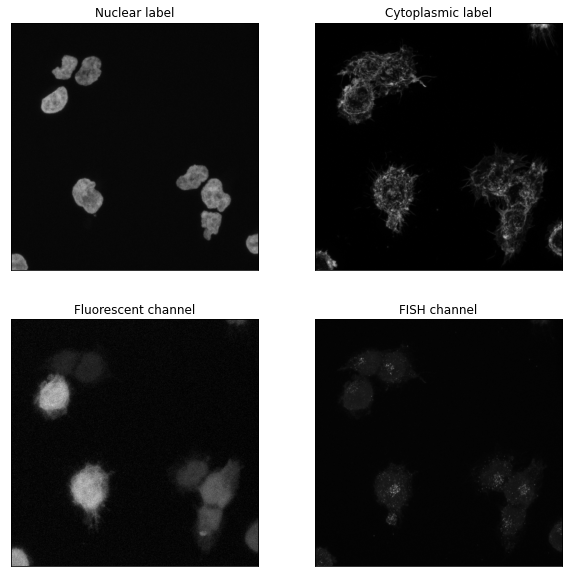

In [17]:
fig,ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].imshow(nuc_image[0,...,0],cmap='gray')
ax[0,0].set_title('Nuclear label')
ax[0,1].imshow(cyto_image[0,...,0],cmap='gray')
ax[0,1].set_title('Cytoplasmic label')
ax[1,0].imshow(fluor_image[0,...,0],cmap='gray')
ax[1,0].set_title('Fluorescent channel')
ax[1,1].imshow(spots_image[0,...,0],cmap='gray')
ax[1,1].set_title('FISH channel')

for i in range(np.shape(ax)[0]):
    for ii in range(np.shape(ax)[1]):
        ax[i,ii].set_xticks([])
        ax[i,ii].set_yticks([])

plt.show()

## Nuclear segmentation

In [10]:
# Initialize nuclear segmentation application
nuc_app = NuclearSegmentation()

In [66]:
# Predict nuclear segmentation
# image_mpp is estimate for pixel size in microns

labeled_im_nuc = nuc_app.predict(nuc_image,image_mpp=0.15)

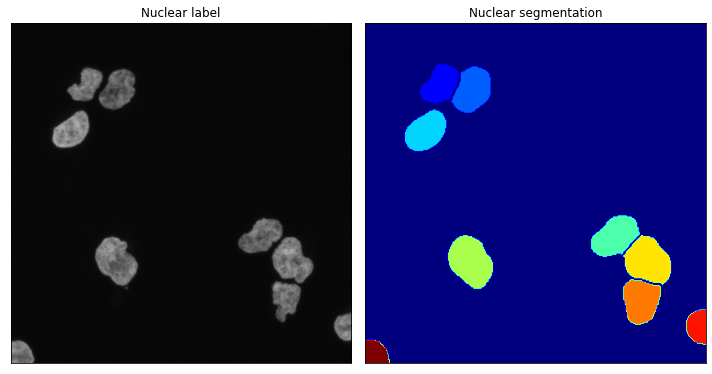

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(nuc_image[0, ..., 0],cmap='gray')
ax[0].set_title('Nuclear label')
ax[1].imshow(labeled_im_nuc[0, ..., 0], cmap='jet')
ax[1].set_title('Nuclear segmentation')

for i in range(len(ax)):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

In [20]:
# Calculate the average intensity of fluorescent image in each segmented nucleus
# Key 0 is image background intensity

mean_nuc_dict = {}

for label in np.unique(labeled_im_nuc):
    labeled_im_2d = labeled_im_nuc[0,:,:,0]
    cell_pixels = np.argwhere(labeled_im_2d==label)

    image_2d = fluor_image[0,:,:,0]
    fluor_pixels = []
    for pixel in cell_pixels:
        fluor_pixels.append(image_2d[pixel[0],pixel[1]])

    mean_nuc_dict[label] = np.mean(fluor_pixels)

## Cytoplasmic segmentation

In [23]:
import tensorflow as tf

#Update this path
model = tf.keras.models.load_model('/data/data-registry/models/cytoplasm/CytoplasmSegmentation')

In [24]:
# Initialize cytoplasm segmentation application
cyto_app = OverrideCytoplamSegmentation(model=model)

In [60]:
# Predict cytoplasmic segmentation
# image_mpp is estimate for pixel size in microns

labeled_im_cyto = cyto_app.predict(fluor_image, image_mpp=0.15)

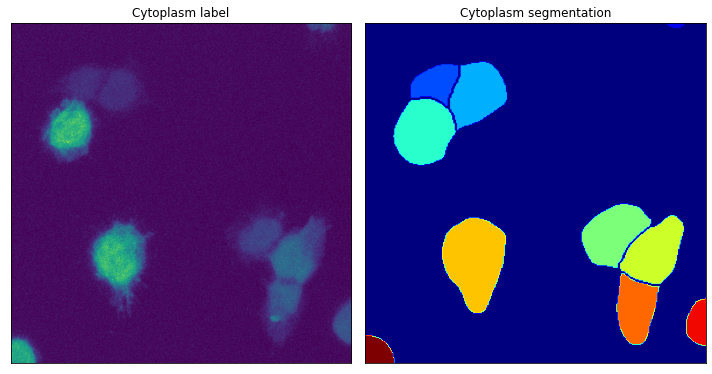

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(fluor_image[0, ..., 0])
ax[0].set_title('Cytoplasm label')
ax[1].imshow(labeled_im_cyto[0, ..., 0], cmap='jet')
ax[1].set_title('Cytoplasm segmentation')
for i in range(len(ax)):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

## Spot detection

In [27]:
# Initialize spot detection application
spots_app = SpotDetection()

In [28]:
# Predict spot locations
# threshold is the threshold probability used to determine spot locations
# threshold=0.95 means that spots returned are predicted to have a 95% chance of being a spot

coords = spots_app.predict(spots_image,threshold=0.97)

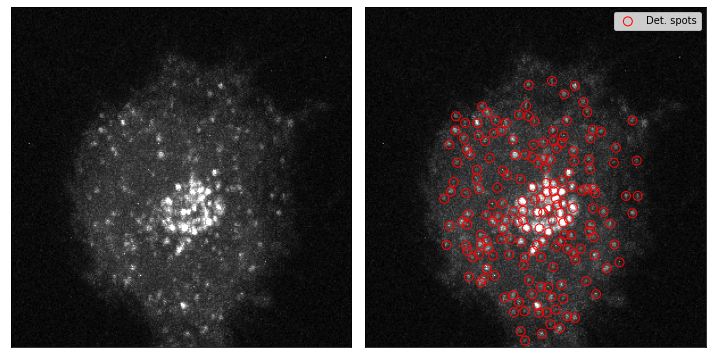

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(spots_image[0, ..., 0],cmap='gray',vmax=75)
ax[1].imshow(spots_image[0, ..., 0],cmap='gray',vmax=75)
ax[1].scatter(coords[0][:,1],coords[0][:,0],facecolors='None',edgecolors='r',label='Det. spots',s=80)
plt.legend()
for i in range(len(ax)):
    ax[i].set_xlim([250,550])
    ax[i].set_ylim([1000,700])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.tight_layout()
plt.show()

## Match spots to cells

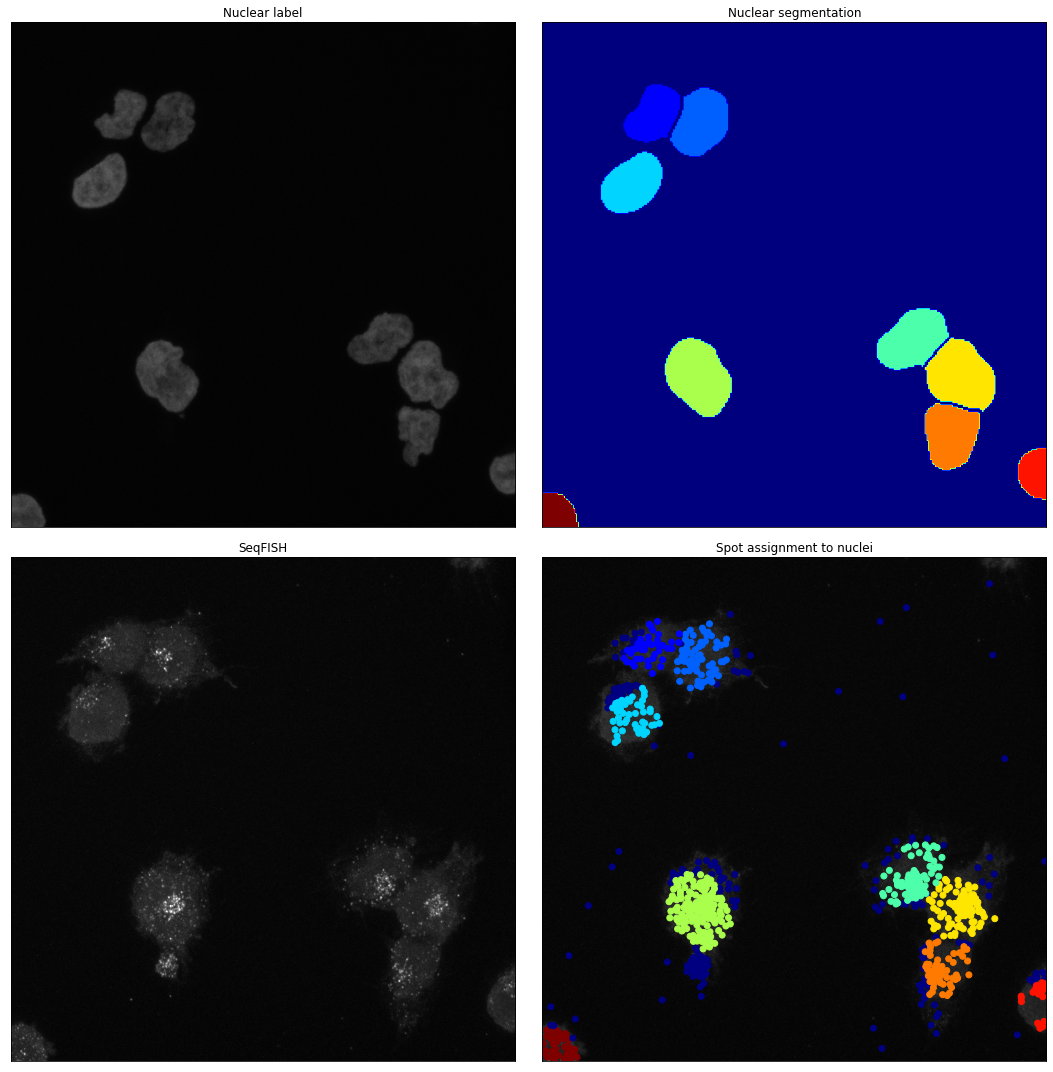

In [68]:
## Assign spots to nuclei

spot_dict_nuc = match_spots_to_cells(labeled_im_nuc,coords[0])
coords_new,cmap_list = process_spot_dict(spot_dict_nuc)

fig,ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].imshow(nuc_image[0,...,0],cmap='gray',vmax=100)
ax[0,0].set_title('Nuclear label')
ax[0,1].imshow(labeled_im_nuc[0,...,0],cmap='jet')
ax[0,1].set_title('Nuclear segmentation')
ax[1,0].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1,0].set_title('SeqFISH')
ax[1,1].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1,1].scatter(coords_new[:,1],coords_new[:,0],c=cmap_list,cmap='jet')
ax[1,1].set_title('Spot assignment to nuclei')

for i in range(np.shape(ax)[0]):
    for ii in range(np.shape(ax)[1]):
        ax[i,ii].set_xticks([])
        ax[i,ii].set_yticks([])

plt.tight_layout()
plt.show()

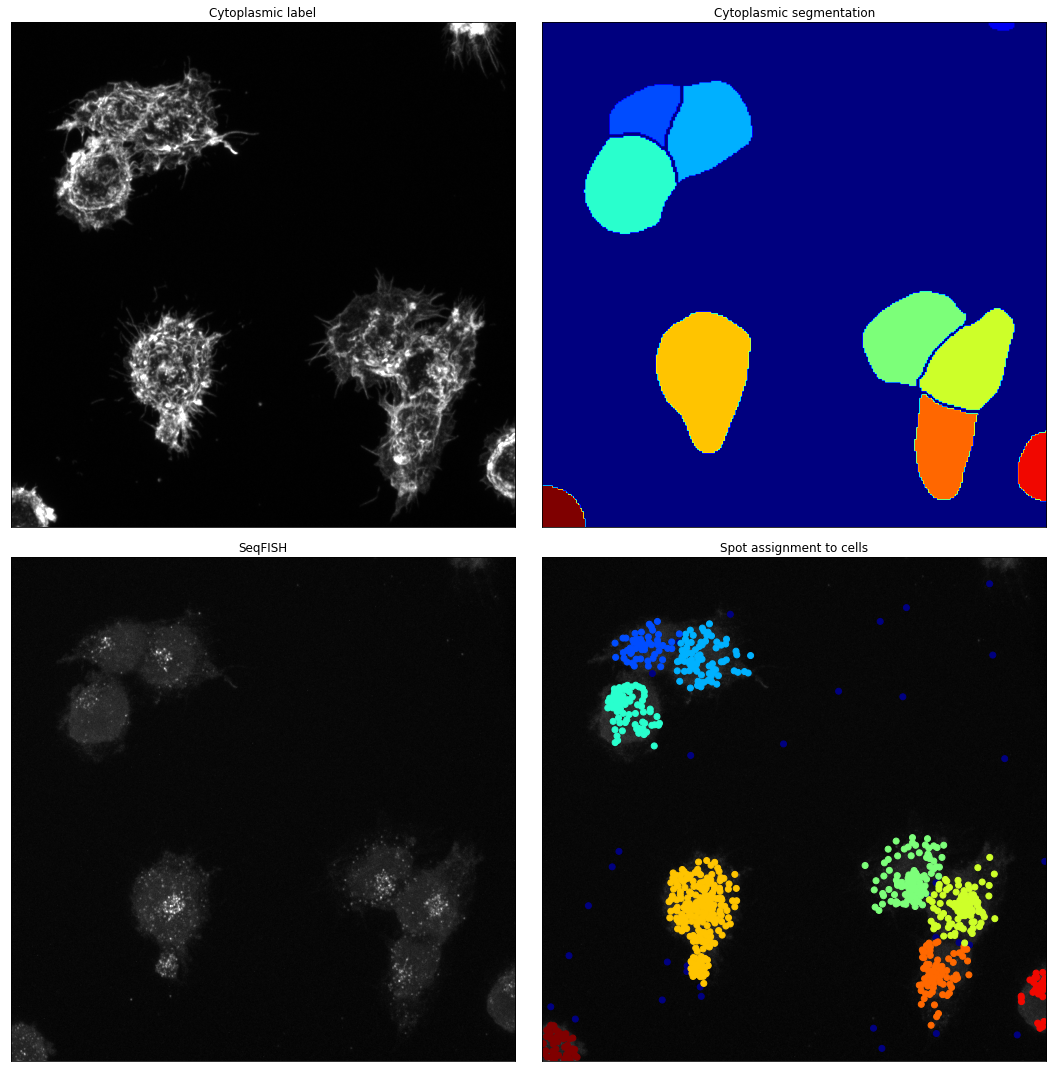

In [72]:
## Assign spots to cytoplasm

spot_dict_cyto = match_spots_to_cells(labeled_im_cyto,coords[0])
coords_new,cmap_list = process_spot_dict(spot_dict_cyto)

fig,ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].imshow(cyto_image[0,...,0],cmap='gray',vmax=100)
ax[0,0].set_title('Cytoplasmic label')
ax[0,1].imshow(labeled_im_cyto[0,...,0],cmap='jet')
ax[0,1].set_title('Cytoplasmic segmentation')
ax[1,0].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1,0].set_title('SeqFISH')
ax[1,1].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1,1].scatter(coords_new[:,1],coords_new[:,0],c=cmap_list,cmap='jet')
ax[1,1].set_title('Spot assignment to cells')

for i in range(np.shape(ax)[0]):
    for ii in range(np.shape(ax)[1]):
        ax[i,ii].set_xticks([])
        ax[i,ii].set_yticks([])

plt.tight_layout()
plt.show()

## Find dots in cytoplasm outside nucleus


In [70]:
# Find spots in cytoplasm but not nucleus

spot_dict_cyto_updated = remove_nuc_spots_from_cyto(labeled_im_nuc,labeled_im_cyto,coords[0])
coords_new,cmap_list = process_spot_dict(spot_dict_cyto_updated)

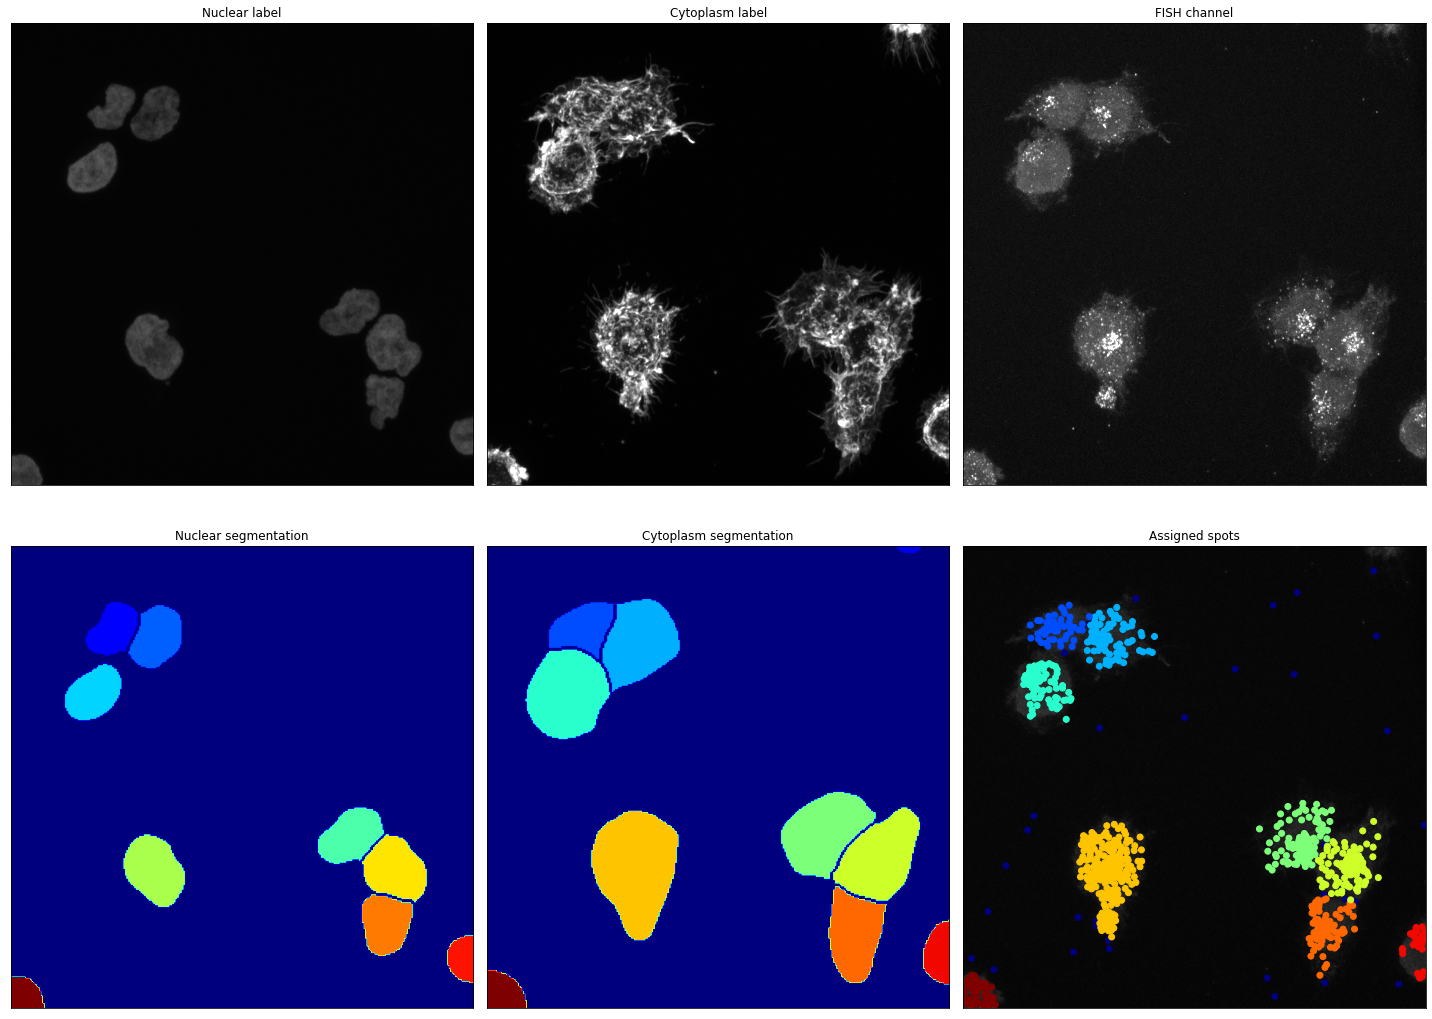

In [73]:
fig,ax = plt.subplots(2,3,figsize=(20,15))

ax[0,0].imshow(nuc_image[0,...,0],cmap='gray',vmax=100)
ax[0,0].set_title('Nuclear label')
ax[1,0].imshow(labeled_im_nuc[0,...,0],cmap='jet')
ax[1,0].set_title('Nuclear segmentation')
ax[0,1].imshow(cyto_image[0,...,0],cmap='gray',vmax=100)
ax[0,1].set_title('Cytoplasm label')
ax[1,1].imshow(labeled_im_cyto[0,...,0],cmap='jet')
ax[1,1].set_title('Cytoplasm segmentation')
ax[0,2].imshow(spots_image[0,...,0],cmap='gray',vmax=50)
ax[0,2].set_title('FISH channel')
ax[1,2].imshow(spots_image[0,...,0],cmap='gray',vmax=100)
ax[1,2].scatter(coords_new[:,1],coords_new[:,0],c=cmap_list,cmap='jet')
ax[1,2].set_title('Assigned spots')

for i in range(np.shape(ax)[0]):
    for ii in range(np.shape(ax)[1]):
    #     ax[i].set_xlim([400,900])
    #     ax[i].set_ylim([700,200])
        ax[i,ii].set_xticks([])
        ax[i,ii].set_yticks([])

plt.tight_layout()
plt.show()